<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Qiskit Aer: Building Noise Models

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

## Introduction

This notebook introduces how to use the Qiskit Aer `noise` module to build custom noise models for noisy simulations.

In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

## Qiskit Aer Noise Module

The `aer.noise` module contains Python classes to build customized noise models for simulation. There are three key classes:

1. The `NoiseModel` class which stores a noise model used for noisy simulation.
2. The `QuantumError` class which describes CPTP gate errors. These can be applied:
    * After *gate* or *reset* instructions
    * Before *measure* instructions.

3. The `ReadoutError` class which describes classical readout errors.

## Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise.errors` submodule and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| --- | --- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarization probability $p$. |
| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of reseting to the $|0\rangle$, $|1\rangle$ state.|
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combining quantum errors

`QuantumError` instances can be combined by using composition, tensor product, and tensor expansion (reversed order tensor product) to produce new `QuantumErrors` as:

 * Composition: $\cal{E}(\rho)=\cal{E_2}(\cal{E_1}(\rho))$ as `error = error1.compose(error2)`
 * Tensor product: $\cal{E}(\rho) =(\cal{E_1}\otimes\cal{E_2})(\rho)$ as `error error1.tensor(error2)`
 * Expand product: $\cal{E}(\rho) =(\cal{E_2}\otimes\cal{E_1})(\rho)$ as `error error1.expand(error2)`

### Example

For example to construct a 5% single-qubit Bit-flip error:

In [2]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(1) = 0.95, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [3]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


In [4]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}]
  P(1) = 0.0475, QasmQobjInstructions = [[{'name': 'z', 'qubits': [1]}]
  P(2) = 0.0475, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(3) = 0.9025, QasmQobjInstructions = [[{'name': 'id', 'qubits': [1]}]


### Converting to and from QuantumChannel operators
 
We can also convert back and forth between `QuantumError` objects in Qiskit Aer and `QuantumChannel` objects in Qiskit Terra.

In [5]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([array([[ 0.00000000e+00+0.j, -2.23606798e-01+0.j],
       [-2.23606798e-01+0.j,  5.99336762e-17+0.j]]), array([[0.97467943+0.j, 0.        +0.j],
       [0.        +0.j, 0.97467943+0.j]])], input_dims=(2,), output_dims=(2,))


In [6]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.9+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.9+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]], input_dims=(2,), output_dims=(2,))


In [7]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.049999999999999996, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.9500000000000001, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]


True

### Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$:

  * $A$ is the *recorded* classical bit value
  * $B$ is the *true* bit value returned from the measurement 
 
E.g. for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$.

In [8]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05


ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

Readout errors may also be combined using `compose`, `tensor` and `expand` like with quantum errors.

## Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are three cases for Quantum Errors:
 
 1. All-qubit quantum error
 2. Specific qubit quantum error
 3. Non-local quantum error
 
### All-qubit quantum error

This applies the same error to any occurrence of an instruction, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [9]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


### Specific qubit quantum error

This applies the error to any occurrence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [10]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', [0]), ('u2', [0]), ('u3', [0])]


### Non-local qubit quantum error

This applies an error to a specific set of noise qubits after any occurrence of an instruction acting on a specific of gate qubits.

It is added as `noise_model.add_quantum_error(error, instructions, instr_qubits, error_qubits)`:

In [11]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0 
error = depolarizing_error(0.05, 1)
noise_model.add_nonlocal_quantum_error(error, ['u1', 'u2', 'u3'], [0], [2])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0, 2]
  Non-local specific qubit errors: [('u1', [0], [2]), ('u2', [0], [2]), ('u3', [0], [2])]


### Executing a noisy simulation with a noise model

* To execute a noisy simulation we pass the noise model object to `QasmSimulator.run` or `execute` using the `noise_model` kwarg.
* Eg: `qiskit.execute(circuits, QasmSimulator(), noise_model=noise)`

**Important:** *When running a noisy simulation make sure you compile your `Qobj` to the same basis gates as the noise model!*

This can be done using `NoiseModel.basis_gates`

# Noise Model Examples

We will now give some examples of noise models. For our demonstrations we will use a simple test circuit generating a n-qubit GHZ state:

In [12]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits, n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure(range(4), range(4))
print(circ)

        ┌───┐          ┌─┐              
q_0: |0>┤ H ├──■───────┤M├──────────────
        └───┘┌─┴─┐     └╥┘     ┌─┐      
q_1: |0>─────┤ X ├──■───╫──────┤M├──────
             └───┘┌─┴─┐ ║      └╥┘┌─┐   
q_2: |0>──────────┤ X ├─╫───■───╫─┤M├───
                  └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
q_3: |0>────────────────╫─┤ X ├─╫──╫─┤M├
                        ║ └───┘ ║  ║ └╥┘
 c_0: 0 ════════════════╩═══════╬══╬══╬═
                                ║  ║  ║ 
 c_1: 0 ════════════════════════╩══╬══╬═
                                   ║  ║ 
 c_2: 0 ═══════════════════════════╩══╬═
                                      ║ 
 c_3: 0 ══════════════════════════════╩═
                                        


### Ideal Simulation

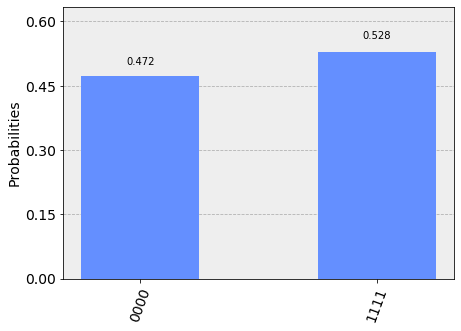

In [13]:
# Ideal execution
job = execute(circ, simulator)
result_ideal = job.result()
plot_histogram(result_ideal.get_counts(0))

## Noise Example 1: Basic bit-flip error noise model

Lets consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1`.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When resetting a qubit reset to 1 instead of 0 with probability `p_reset`.
* When measuring a qubit, flip the state of the qubit with probability `p_meas`.

In [14]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'u1', 'reset', 'u2', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Executing the noisy simulation

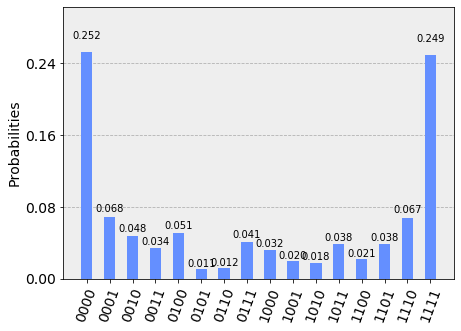

In [15]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_bit_flip.basis_gates,
              noise_model=noise_bit_flip)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

## Example 2: T1/T2 thermal relaxation

Now consider a more realistic error model based on thermal relaxation with the qubit environment:
* Each qubit is parameterized by a thermal relaxation time constant $T_1$ and a dephasing time constant $T_2$.
* Note that we must have $T_2 \le 2 T_1$.
* Error rates on instructions are determined by gate times and qubit $T_1$, $T_2$ values.

In [16]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'reset', 'u2', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


### Executing the noisy simulation

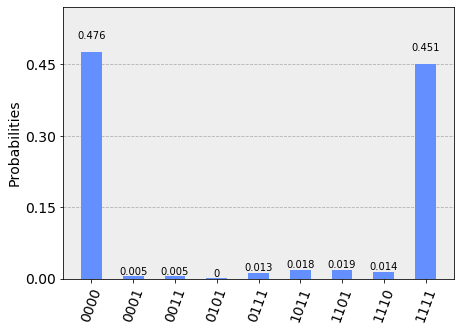

In [17]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright